# **Coronary Artery Segmentation from Intravascular Optical Coherence Tomography Using Deep Capsules - Arjun Balaji**

First off, shameless plug for our group, [VASCLAB](https://vasclab.mech.uwa.edu.au/).

## Introduction

In this notebook presentation I will show you how to train, validate and test a [Capsule Network](https://towardsdatascience.com/capsule-networks-the-new-deep-learning-network-bd917e6818e8) on a dataset of coronary artery IVOCT B-scans. This work was done at VascLabs and was designed with current fluid solver software in mind. 

Some of the key goals and aims of this project:
1. production of a deep learning model that is at least state of the art at binary IVOCT segmentation, measured by the [Dice Score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).
2. the final masks should be compatible with modern fluid solver software; be reliable and produce smooth (or at least easily smoothable) masks.
3. segment whole B-scans in under 30 seconds. This is required for feasible use in theatre.

In this talk I will show you the data we are working with, how we build the model, how we train and validate the model and some analysis of the results at the end. 

I will explain concepts as we go along, but if you have any questions please ask away! 


**Only execute this code if you require the collapsible headings:** \
#!  conda install -y -c conda-forge nodejs 
#! jupyter labextension install @aquirdturtle/collapsible_headings

Firstly we start by importing the appropriate modules, you'll notice most of these are system default ones, and the rest are deep learning toolkits.

In [1]:
%matplotlib inline

In [2]:
import os
from fastai.vision import *
from fastai.callbacks import * 

ModuleNotFoundError: No module named 'fastai'

In [3]:
os.chdir(Path('/workspace/oct_ca_seg/'))

In [4]:
from fastai.vision import *
from fastai.metrics import *
import torch.nn as nn
import numpy as np
import PIL.Image as pil
import torch.functional as F
from fastai.utils.mem import *
from pathlib import Path
import itertools
import sys
import seg_model.src.model as m
import skimage.transform as skitra
from oct_ca.exp.nb_caps import one_group_selective_freeze

Next we get a path for our data and get a list that tells us what subset of our data is going to be used for testing.

In [5]:
data_path = Path('/workspace/oct_ca_seg/data_oct')

In [6]:
valid_names = list(np.load(Path('/workspace/oct_ca_seg/runsaves/Final1-pawsey/analysis/testNAMES.npy')))

In [7]:
for i, name in enumerate(valid_names):
    name = Path(data_path/('images/' + name[:-4] + '.jpg'))
    valid_names[i] = name

Wrap our list of data in a class so it plays nice with fastai.

In [8]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_oct_mask(fn)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

I have a pretrained capsnet body, so I also need to load which images I used the model on to train and validate, it wouldn't be fair to start validating on images the model has previously seen in the training phase.

In [9]:
%%time
def load_name_sets(path, valid_names):
    allnames = get_image_files(path)
    train = []
    valid= []
    for i, name in enumerate(allnames):
        if name in valid_names: valid.append(name)
        else: train.append(name)
    return train, valid
            
train, valid = load_name_sets(data_path/'images', valid_names)

CPU times: user 14.3 s, sys: 2.15 ms, total: 14.4 s
Wall time: 14.4 s


**Execute this collapsed code if you would like to get the mean and standard deviation of you're train/valid sets**

path_img = data_path/'images'

get_y_fn = lambda x: data_path/'labels'/x.name

saved_us, saved_stds = ([0.2158, 0.1964, 0.1908], [0.0418, 0.0194, 0.0138])
saved_stats = (saved_us, saved_stds)

src = (SegItemListCustom.from_folder(path_img)
       .split_by_idxs(train_idx=trainidx, valid_idx=valididx)
       .label_from_func(get_y_fn,classes=['background','lumen']))

metrics=[acc,sens,spec,mydice]
size=256
bs=1
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=4)
        .normalize(saved_stats))

### Loading Original Dataset

In [10]:
from seg_model.nbs.useful.dataset import *

Here is a dictionary containing all the parameters we used!

In [11]:
opts = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'cuda' : True,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'start_size': (256, 256),
'device': 'cuda',
'input_images': [0,1,2],
'transforms':False,      
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 1,
'inputchannels': 3,
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'uptype': 'deconv',
}

In [12]:
optsagain = {'activation': 'relu',
'batch_size': 2,
'c_size': (256, 256),
'comet': False,
'dataroot': '/workspace/oct_ca_seg/data_oct',
'device': 'cuda',
'dims1': 24,
'dims2': 32,
'dims3': 48,
'epochs': 40,
'f1dims': 32,
'f1maps': 2,
'f2dims': 16,
'f2maps': 2,
'inputchannels': 3,
'la': 0.1,
'lb': 1,
'lc': 0.05,
'loadcheckpoint': '/workspace/oct_ca_seg/runsaves/Final1-pawsey/checkpoints/checkpoint.pt',
'location': 'pawsey',
'logging': True,
'lr': 0.0008,
'maps1': 8,
'maps2': 16,
'maps3': 24,
'nThreads': 8,
'name': 'Final1-pawsey',
'normalization': 'batch',
'primdims': 16,
'primmaps': 4,
'reconchannels': 1,
'runsaves_dir': '/group/pawsey0271/abalaji/projects/oct_ca_seg/run_saves',
'save': True,
'sgamma': 0.8,
'sstep': 50,
'start_size': (256, 256),
'test': True,
'train': True,
'transforms': True,
'uptype': 'deconv',
'val': True,
'verbose': True}

**Loading capsnet body options and wrapping them in a class for easier/clearer reference later.**

In [13]:
class Options():
    def __init__(self, dictionary):
        
        for k,v in dictionary.items():
            setattr(self, k, v)

In [14]:
opts = Options(opts)
optsagain = Options(optsagain)

## Dataset

This is our custom normalise function that returns normalised images, this makes our model train faster.

In [15]:
def normalize(octimage):
    means = octimage.view(3,-1).mean(-1)
    stds = octimage.view(3,-1).std(-1)
    return (octimage - means[:,None,None])/stds[:,None,None]

In [16]:
#dataset class
class OCTDataset(Dataset):
    """
    First we create a dataset that will encapsulate our data. It has 3 special 
    functions which will be explained as they go. We will pass this dataset object
    to the torch dataloader object later which will make training easier.
    """
    def __init__ (self,
                  main_data_dir,
                  name_list,
                  start_size,
                  cropped_size,
                  transform,
                  input_images,
                  cuda):
        self.nl = name_list
        self.main_data_dir = main_data_dir
        self.start_size = start_size
        self.transform = transform
        self.cropped_size = cropped_size
        self.input_images = input_images
        self.cuda = cuda
        
        self.rcrop = RandomCrop(self.cropped_size)
        self.phflip = np.random.rand()
        self.pvflip = np.random.rand()
        self.spnoise = SPNoise(1)
        
        '''
        #iterate through the 2d images and get all their names
        name_list = []
        for im in os.listdir(os.path.join(self.main_data_dir, 'images')):
            filename = os.fsdecode(im)
            name_list.append(filename)
        ''' 
        self.name_list = name_list
        
    def visualise(self, idx):
        
        sample = self.__getitem__(idx)
        #print(sample['input'].size())
        #print(sample['label'].size())
        input_data = sample['input'].cpu().numpy()[0,:,:]
        l_data = sample['label'].cpu().numpy()[0,:,:]

        
        
        f, (axin, axl, ax1comb) = plt.subplots(1,3, sharey=True, figsize=(18,16))
        f.subplots_adjust(hspace=0.3)
        plt.tight_layout()
        
        #plot image
        image = axin.imshow(input_data,
                            aspect = 'equal')
        axin.set_title('Input', fontsize=40)
        f.colorbar(image, ax=axin, orientation='vertical', fraction = 0.05)
        
        axl.imshow(l_data,
                   aspect = 'equal')
        axl.set_title('Label', fontsize=40)
        
        combined = input_data + 10 * l_data 
        
        
        ax1comb.imshow(combined, aspect = 'equal')
        ax1comb.set_title('Overlayed', fontsize=40)
        plt.show()
        
    def __getitem__(self, idx):
        """This function will allow us to index the data object and it will 
        return a sample."""
        name = self.name_list[idx]
        
        #load data  
        label = np.array(pil.open(name.parent.parent/str('labels/' + name.name)))
        #print(Path('/workspace/oct_ca_seg/data_oct/labels/')/str(name))
        #print(label.shape)
        
        image = np.array(pil.open(name))
        
        image = image.astype(float)
        label = label.astype(float)
        #print(image.shape)
        
        #print(label.max())
        #print(Image.shape)
        if self.transform:
            
            ysize = self.start_size[0] + 20
            xsize = self.start_size[1] + 20
            image = skitransforms.resize(image, output_shape=(ysize, xsize))
            label = skitransforms.resize(label, output_shape=(ysize, xsize))
            
            
            #print(label.shape)
            #print(label.max())
            image, label = self.rcrop(image, label)
            #print(label.max())
            
            if self.phflip>0.5:
                #hflip
                image = np.flip(image, 1)
                label = np.flip(label, 1)    
                #print(label.max())
            #print(label.shape)
            
            if self.pvflip>0.5:
                #vflip
                image = np.flip(image, 0)
                label = np.flip(label, 0)
                #print(label.max())
            #print(label.shape)
            
            angle = np.random.randint(0,360)
            image = skitransforms.rotate(image, angle=angle, mode='reflect')
            label = skitransforms.rotate(label, angle=angle, mode='reflect')
            #print(label.max())
            #print(label.shape)
            
            if np.random.rand() > 0.9:
                image = self.spnoise(image)
            
            if np.random.rand() > 0.5:
                image = gaussian(image, sigma=1, mode='reflect')
            
            
        else:
            image = skitransforms.resize(image, output_shape= self.start_size)
            label = skitransforms.resize(label, output_shape= self.start_size)
        
        #image = np.expand_dims(preprocessing.scale(image[:,:,0]), -1)
        
        label = np.transpose(label.copy(), (2, 0, 1))
        image = np.transpose(image.copy(), (2, 0, 1))
        #og = preprocessing.MinMaxScaler(og)
        
        label = torch.tensor(label).float()
        
        label = torch.gt(label.sum(dim=0).unsqueeze(0), 200).float()
        
        image = torch.tensor(image).float()
        #print(image.size(), label.shape)
        image = normalize(image)
        
        
        sample = {'input': image[self.input_images],
                  'label': label,
                  'case_name': [str(name.name)]}

        return sample
    
    def __len__(self):    
        """This function is mandated by Pytorch and allows us to see how many 
        data points we have in our dataset"""
        return len(self.name_list)
    


Load up our train and valid sets.

In [17]:
oct_data_t = OCTDataset(data_path/'images', train, opts.start_size,opts.c_size,True,opts.input_images, opts.cuda)
oct_data_v = OCTDataset(data_path/'images', valid, opts.start_size,opts.c_size,opts.transforms,opts.input_images, opts.cuda)

Here are the sizes of both datasets:

In [18]:
len(oct_data_t),len(oct_data_v) 

(9608, 2403)

In [19]:
bs = 1

In [20]:
oct_load_t = DataLoader(oct_data_t, batch_size=bs, shuffle=False)
oct_load_v = DataLoader(oct_data_v, batch_size=1, shuffle=False)

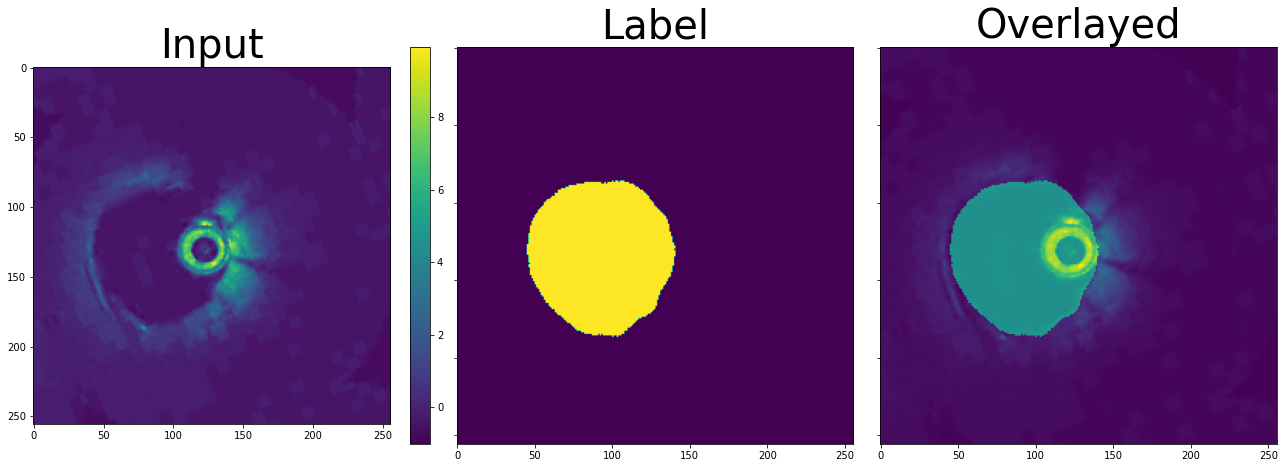

In [21]:
oct_data_t.visualise(644)

## The Model

In [22]:
model = m.CapsNet(opts);
model.to(opts.device);

In [23]:
modelfake = m.CapsNet(optsagain);
modelfake.to(opts.device);

Add a final Gaussian Blur Module to the models.

### Smoothing

In [24]:
#export
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

In [25]:
class GaussianAndResizing(nn.Module):
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianAndResizing, self).__init__()
        self.smooth = GaussianSmoothing(channels, kernel_size, sigma, dim)
    
    def smoothing(self, x):
        xs = x.size()
        #print(x.size())
        x = x.permute(0,1,4,2,3).reshape([xs[0], int(xs[1]*xs[4]), xs[2], xs[3]])
        #print(x.size())
        x = self.smooth(x)
        x=F.pad(x, (2,0,2,0), 'reflect')
        #print(x.size())
        x = x.view([xs[0], int(xs[1]), int(xs[4]), xs[2], xs[3]]).permute(0,1,3,4,2)
        return x
    
    def forward(self,x):
        #print(self.smoothing(x).size())
        return self.smoothing(x)

**Add Gaussian filter inbetween last two layers to get rid of grid artefacts.**

In [26]:
model.get_abstract_caps_final2 = nn.Sequential(modelfake.get_abstract_caps_final2, GaussianAndResizing(32, 3, 2).to(opts.device))
model.get_abstract_caps_final1 = nn.Sequential(modelfake.get_abstract_caps_final1, GaussianAndResizing(64, 3, 2).to(opts.device))

In [27]:
model.load_state_dict(torch.load(Path('/workspace/oct_ca_seg/runsaves/capstunedarj1.pt')))

<All keys matched successfully>

In [28]:
loaded_state = torch.load(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/0caps_scratch.pt'))
model.load_state_dict(loaded_state['model'])

<All keys matched successfully>

In [29]:
del modelfake #clear some mem

In [30]:
model = model.cuda()

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [32]:
count_parameters(model)

122560961

In [76]:
torch.save(model.state_dict(), Path('/workspace/oct_ca_seg/runsaves/capstunedarj1cpu.pt'))

**Freezing the body and leaving only the last two layers with learnable parameters.**

In [43]:
model = one_group_selective_freeze(model, 'get_abstract_caps_final1')

### Metric definitions

In [33]:
def sens(c, l):
    n_targs=l.size()[0]
    c = c.argmin(dim=1).view(n_targs,-1).float()
    l=l.view(n_targs, -1).float()
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l) - inter
    return (inter/union).mean()

In [34]:
def spec(c, l):
    n_targs=l.size()[0]
    c = c.argmin(dim=1).view(n_targs,-1).float()
    l = l.view(n_targs,-1).float()
    c=1-c
    l=1-l
    inter = torch.sum(c*l, dim=(1))
    union = torch.sum(c, dim=(1)) + torch.sum(l) - inter
    return (inter/union).mean()

In [35]:
def acc(c, l):
    n_targs=l.size()[0]
    c = c.argmin(dim=1).view(n_targs,-1).float()
    l = l.view(n_targs,-1)
    c = torch.sum(torch.eq(c,l).float(),dim=1)
    return (c/l.size()[-1]).mean()

In [36]:
def mydice(c,l, iou:bool=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = l.shape[0]
    c = c.argmin(dim=1).view(n,-1).float()
    l = l.view(n,-1)
    intersect = (c * l).sum().float()
    union = (c+l).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return (intersect / (union-intersect+eps) if union > 0 else union.new([1.]).squeeze())

In [37]:
    
def lossdice(c,l, iou:bool=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = l.shape[0]
    c = c.view(n,-1).float()
    l = l.view(n,-1)
    intersect = (c * l).sum().float()
    union = (c+l).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return (intersect / (union-intersect+eps) if union > 0 else union.new([1.]).squeeze())

## Training

In [38]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [39]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2

In [40]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = torch.tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

sched = combine_scheds([0.4, 0.6], [sched_cos(1e-08, 1e-04), sched_cos(1e-04, 2e-9)])

In [41]:
def channelify(mask):
    #bin mask shape 1,h,w - gives background class
    zeroth = 1-mask
    return torch.cat((mask, zeroth), 1)

In [42]:
new_loss = lambda x,y: torch.nn.functional.binary_cross_entropy(x,y) + 0.05*lossdice(x,y)

In [43]:
import pandas as pd

In [44]:
metric_data_t = pd.DataFrame(columns=['sensitivity', 'specificity', 'dice', 'accuracy', 'loss', 'lr'])
metric_data_v = pd.DataFrame(columns=['sensitivity', 'specificity', 'dice', 'accuracy', 'loss'])

In [45]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [46]:
#optimizer = loaded_state['optimizer']

In [47]:
model.train();

In [48]:
epochs = 1

In [49]:
bpe = epochs*len(oct_data_t)/bs

In [ ]:
%%time 

niter = 0.
for epoch in range(epochs):
    for i, sample in enumerate(oct_load_t):
        last_lr = sched(niter)
        optimizer.param_groups[0]['lr'] = last_lr
        xb, yb, name = sample['input'].cuda(), sample['label'].cuda(), sample['case_name'][0][0]
        pred = model(xb)[0]
        
        
        optimizer.zero_grad()

        loss = new_loss(pred, channelify(yb))

        loss.backward()
        optimizer.step()  


        #now we want to save metrics for analysis 
        sn = float(sens(pred, yb).cpu())
        spn = float(spec(pred,yb).cpu())
        dn = float(lossdice(pred, channelify(yb)).cpu())
        accn = float(acc(pred,yb).cpu())
        
        neat = [sn,spn,dn,accn, float(loss.data.cpu()), last_lr]
        
        name = str(epoch) + '.' + name
        metric_data_t.loc[name] = neat
        
        if i%50==0: print(i, 'dice: ', dn, 'loss', neat[4])
        niter += 1/bpe

metric_data_t = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_t'))

In [61]:
metric_data_t.to_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/1caps_scratch_arj_metrics_t')) 

In [60]:
metric_data_t = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/0caps_scratch_arj_metrics_t'))

In [115]:
def loss_plot(l, mode):
    if mode not in ['v','t']:
        return
    if mode=='v': title='During Validation'
    if mode=='t': title='During Training'
        
    fig = plt.figure()
    plt.plot(l)
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

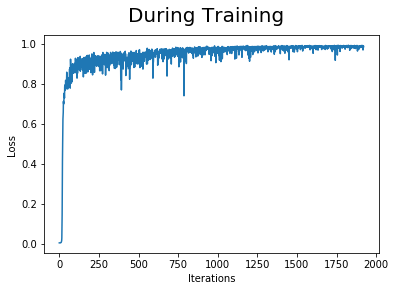

In [119]:
loss_plot(list(metric_data_t['dice'][0:-1:5]), 't')

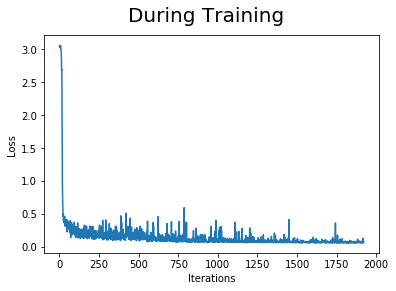

In [120]:
loss_plot(list(metric_data_t['loss'][0:-1:5]), 't')

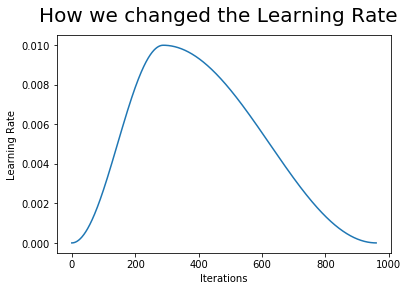

In [121]:
l = list(metric_data_t['lr'])[0:-1:10]
fig = plt.figure()
plt.plot(l)
fig.suptitle('How we changed the Learning Rate', fontsize=20)
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.show()

In [122]:
#state = {'model': model.state_dict(),'optimizer': optimizer}

In [123]:
#torch.save(state, '/workspace/oct_ca_seg/seg_model/nbs/useful/0caps_scratch.pt')

## Validation

In [124]:
model.eval();

In [125]:
oct_load_v = DataLoader(oct_data_v, batch_size=1, shuffle=False)

In [126]:
model = model.cuda()

In [66]:
%%time 
#valid loop
for i, sample in enumerate(oct_load_v): 
    xb, yb, name = sample['input'].cuda(), sample['label'].cuda(), sample['case_name'][0][0]
    
    pred = model(xb)[0]
    loss = new_loss(pred, channelify(yb))
    
    #now we want to save metrics for analysis 
    sn = float(sens(pred, yb).cpu())
    spn = float(spec(pred,yb).cpu())
    dn = float(mydice(pred, yb).cpu())
    accn = float(acc(pred,yb).cpu())
    metric_data_v.loc[name] = [sn,spn,dn,accn, float(loss.data.cpu())]

CPU times: user 25min 41s, sys: 2min 21s, total: 28min 2s
Wall time: 4min 41s


In [127]:
len(oct_data_v)/(120+23)

16.804195804195803

it took 2 mins 23 seconds to go through and segment the whole test set 2403 images with a bs of 5. this equates to 16.8 images/second which is 1 image per 0.06 seconds. 

in cpu mode bs = 1 and it takes 

In [136]:
#metric_data_t = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/0caps_scratch_arj_metrics_t'))
#metric_data_v = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/0caps_scratch_arj_metrics_v'))

In [59]:
metric_data_t = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_t'))
metric_data_v = pd.read_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_v'))

In [60]:
import numpy as np

In [61]:
from skimage import filters

## Analysis

In [62]:
class Analysis():
    def __init__(self, data, model):
        self.d = data
        self.m = model
        
    
    def show_a_pred(self, name):
        
        i = self.d.nl.index(name)
        
        fig, (axim, axl, axb, axlu, axpr, axunc) = plt.subplots(nrows=1, ncols=6, figsize=(16, 3.5),
                    subplot_kw={'xticks': [], 'yticks': []})
        
        input, target, name = self.d[i]['input'], self.d[i]['label'], self.d[i]['case_name'][0]
        input = input.unsqueeze(0)
        target = target.unsqueeze(0)
        pred = self.m(input.cuda())[0]
        
        im = axim.imshow(input.cpu()[0][0])
        axim.set_title('Image')
        
        l = axl.imshow(target.cpu()[0][0])
        axl.set_title('Label')
        
        pred = pred.cpu().detach()
        background = axb.imshow(pred[0][1])
        axb.set_title('P(background)')
        
        lumen = axlu.imshow(pred[0][0])
        axlu.set_title('P(lumen)')
        
        preds = axpr.imshow(pred.argmin(dim=1)[0].numpy())
        axpr.set_title('Prediction')
        
        unc = axunc.imshow(pred[0][0] * (1 - pred.argmin(dim=1)[0].float()))
        axunc.set_title('Residual')
        
        fig.suptitle(str(name) + ' -  Dice Score = ' + str(np.round(float(mydice(pred, target)),6)), fontsize=22)

        #print(name,  float(mydice(pred, target)))
    
    def worst_to_best(self, whichones, sorted_dices, save=False):
        
        
        inds = list(map(self.d.nl.index, whichones))
        
        fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(16,10),# for paper figsize=(6.5, 4.77)
                        subplot_kw={'xticks': [], 'yticks': []})
        
        i=0
        for ax, ting in zip(axs.flat, inds):
            input, target, name = self.d[inds[i]]['input'], self.d[inds[i]]['label'], self.d[inds[i]]['case_name'][0]
            input, target = input.unsqueeze(0), target.squeeze()
            pred = self.m(input.cuda())[0].argmin(dim=1).squeeze()
            input = input.squeeze()
            
            pred = pred.cpu()
            pred = np.ma.masked_where(pred==0,pred)
            target = filters.sobel(target) *100
            label_pic = np.ma.masked_where(target==0, target)
            
            im = ax.imshow(input[0],'gray', interpolation='none')
            la = ax.imshow(1-pred, 'RdYlGn', interpolation='none', alpha=0.7)
            acla = ax.imshow(label_pic, 'inferno', interpolation='none')
            ax.set_title(str(i+1) + '.    Dice: ' + str(np.round(100*sorted_dices['dice'][whichones[i].name],2)),fontsize=20)
            i+=1
        
        plt.tight_layout()
        if save:
            plt.savefig('/workspace/oct_ca_seg/seg_model/nbs/a10worstbestmiddle.jpg', bbox_inches='tight', dpi=1000)
    
    def show_interestingx4(self, four, sorted_dices, save=False):
        
        
        inds = list(map(self.d.nl.index, four))
        
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 8), #figsize=(6.5, 4.77) for paper
                        subplot_kw={'xticks': [], 'yticks': []})
        
        i=0
        for ax, ting in zip(axs.flat, inds):
            input, target, name = self.d[inds[i]]['input'], self.d[inds[i]]['label'], self.d[inds[i]]['case_name'][0]
            input, target = input.unsqueeze(0), target.squeeze()
            pred = self.m(input.cuda())[0].argmin(dim=1).squeeze()
            input = input.squeeze()
            
            pred = pred.cpu()
            pred = np.ma.masked_where(pred==0,pred)
            target = filters.sobel(target) *100
            label_pic = np.ma.masked_where(target==0, target)
            
            im = ax.imshow(input[0],'gray', interpolation='none')
            la = ax.imshow(1-pred, 'RdYlGn', interpolation='none', alpha=0.4)
            acla = ax.imshow(label_pic, 'inferno', interpolation='none')
            ax.set_title(str(i+1) + '.    Dice: ' + str(np.round(100*sorted_dices['dice'][four[i].name],2)),fontsize=22)
            i+=1
        
        plt.tight_layout()
        if save:
            plt.savefig('/workspace/oct_ca_seg/seg_model/nbs/interesting.jpg', bbox_inches='tight', dpi=1000)
            

In [63]:
analysis = Analysis(oct_data_v, model)

**Execute this to save metric data** 

#metric_data_t.to_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_t')) \
#metric_data_v.to_csv(Path('/workspace/oct_ca_seg/seg_model/nbs/useful/capstunedarj1_metrics_v'))

In [64]:
dice = metric_data_v[['Unnamed: 0', 'dice']]

In [65]:
dice = dice.set_index('Unnamed: 0');

In [66]:
def sorter_boy(metric):
    metric = metric.sort_values('dice', ascending=True)
    for i in metric:
        i = Path(analysis.d.main_data_dir/str(i))
    return metric

In [67]:
sorted_dices=sorter_boy(dice)

**Here is the mean dice score of our model on the 2403 validaton images.**

In [68]:
sorted_dices.mean(), sorted_dices.median() 

(dice    0.971068
 dtype: float64, dice    0.981443
 dtype: float64)

In [69]:
metric_data_v['sensitivity'].mean(), metric_data_v['specificity'].mean(),  metric_data_v['accuracy'].mean(),  metric_data_v['dice'].mean() 

(0.9463379245051433,
 0.9947569550348727,
 0.9952646065790158,
 0.9710675365866297)

In [70]:
metric_data_v['sensitivity'].std(), metric_data_v['specificity'].std(),  metric_data_v['accuracy'].std(),  metric_data_v['dice'].std() 

(0.06347402050062224,
 0.0076772255121104254,
 0.006904932723988056,
 0.04215547033339235)

In [71]:
metric_data_v['sensitivity'].median(), metric_data_v['specificity'].median(),  metric_data_v['accuracy'].median(),  metric_data_v['dice'].median() 

(0.9635612964630128,
 0.9968863725662231,
 0.9971466064453124,
 0.9814425706863404)

In [72]:
ascend_dice_names = sorted_dices.index.values.tolist();

get the names and respective paths

In [73]:
name_paths = pd.DataFrame(columns =['path'])
for i, name in enumerate(ascend_dice_names):
    inddd = name
    name = Path(analysis.d.main_data_dir/name)
    name_paths.loc[inddd] = name

In [74]:
sorted_dices = sorted_dices.join(name_paths)

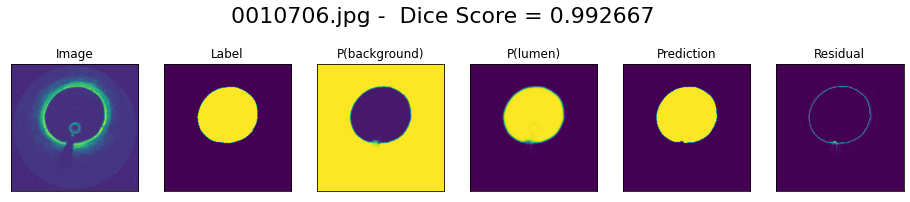

In [75]:
analysis.show_a_pred(sorted_dices['path'][2400]) #120

With the above tool you can go through the validation data set and inspect model predictions. From left to right this plot shows; the image, the label the background class probabilities, the lumen class probabilities, the final prediction, the residual.

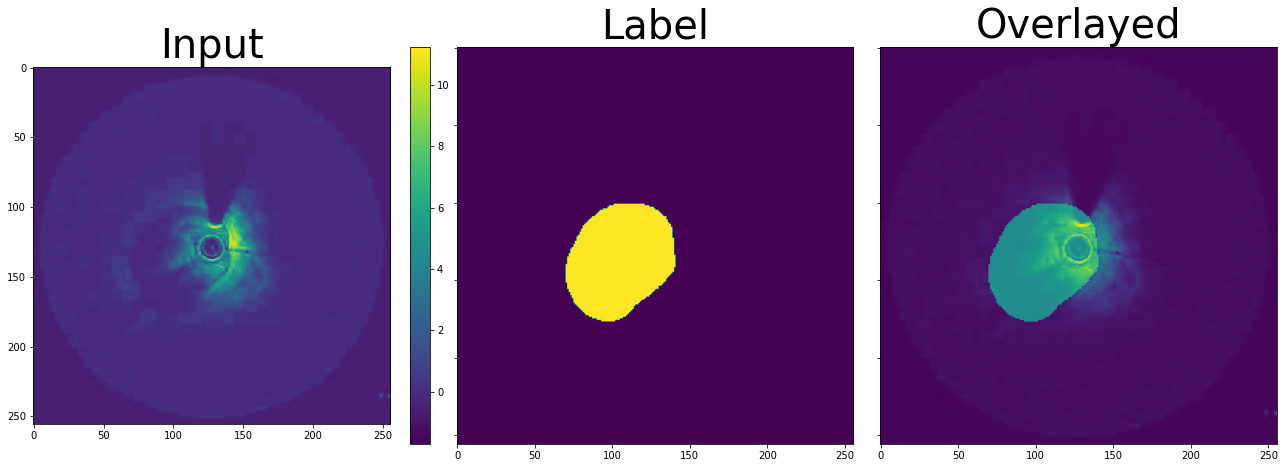

In [76]:
oct_data_v.visualise(257);

We observe that more than 95% of the predictions are better than 92%. Why 92% you may ask?

In [77]:
(dice['dice']>0.92).sum()/2403

0.9521431543903454

Text(0, 0.5, 'N')

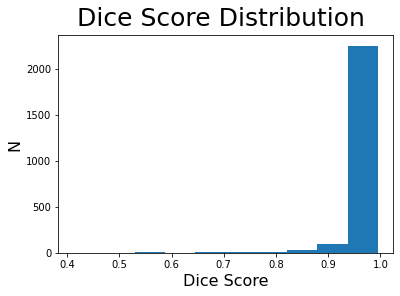

In [78]:
fig = plt.figure()
plt.hist(dice['dice'])
fig.suptitle('Dice Score Distribution', fontsize=25)
plt.xlabel('Dice Score', fontsize=16)
plt.ylabel('N', fontsize=16)

Text(0, 0.5, 'Dice Score (%)')

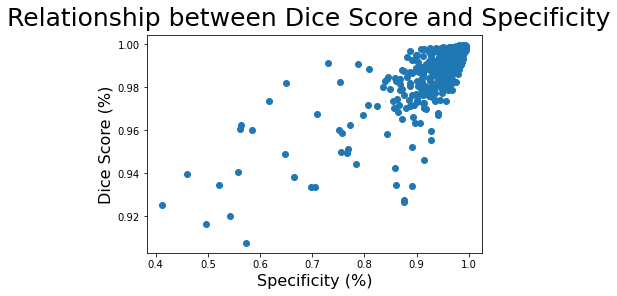

In [79]:
fig = plt.figure()
plt.scatter(metric_data_v['dice'], metric_data_v['specificity'])
fig.suptitle('Relationship between Dice Score and Specificity', fontsize=25)
plt.xlabel('Specificity (%)', fontsize=16)
plt.ylabel('Dice Score (%)', fontsize=16)

Text(0, 0.5, 'Dice Score (%)')

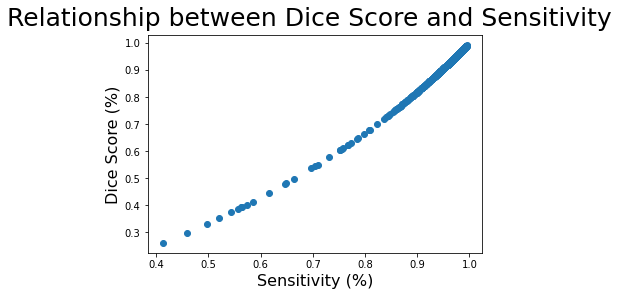

In [80]:
fig = plt.figure()
plt.scatter(metric_data_v['dice'], metric_data_v['sensitivity'])
fig.suptitle('Relationship between Dice Score and Sensitivity', fontsize=25)
plt.xlabel('Sensitivity (%)', fontsize=16)
plt.ylabel('Dice Score (%)', fontsize=16)

The Dice Scores and specificity are poorly correlated because the Dice score is only dependent on the ability of the model to correctly label lumen cells. 

The Dice Scores and sensitivity highly correlated because of this reason.

Text(0.5, 0, 'Dice Scores')

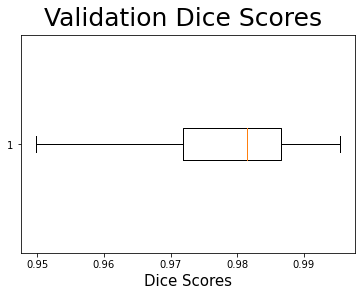

In [81]:
fig = plt.figure() 
plt.boxplot(dice['dice'],vert=False,showfliers=False)
fig.suptitle('Validation Dice Scores', fontsize=25)
plt.xlabel('Dice Scores', fontsize=15)

Text(0.5, 0, 'Sensitivity')

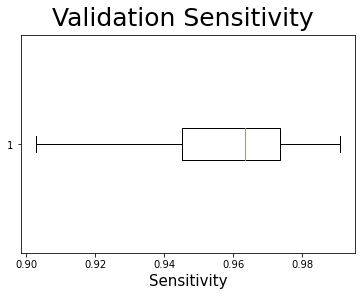

In [82]:
fig = plt.figure() 
plt.boxplot(metric_data_v['sensitivity'],vert=False,showfliers=False)
fig.suptitle('Validation Sensitivity', fontsize=25)
plt.xlabel('Sensitivity', fontsize=15)

### Uncertainty 

0009870.jpg


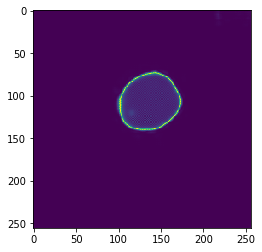

In [60]:
sample = oct_data_v[120]
print(sample['case_name'][0])
dummy_in = (sample['input'].unsqueeze(0)).cuda()
dummy_out = model(dummy_in)[0].cpu().detach()
plt.imshow((1-((dummy_out[0][1]-dummy_out[0][0])**2)**0.5))

In [ ]:
%%time
uncdata = pd.DataFrame(columns=['mean', 'std', 'sum', 'l_area','pred_area', 'met1', 'met2'])
for i, sample in tqdm.tqdm(enumerate(oct_load_v)): 
    xb, yb, name = sample['input'].cuda(), sample['label'].cuda(), sample['case_name'][0][0]
    
    pred = model(xb)[0]
    '''
    argp = pred[0][0] * (1 - pred.argmin(dim=1)[0].float())
    argi = argp.sum().cpu()
    
    argabsolute = (argp>0.05).sum().cpu()'''
    
    met1 = float(((1-pred.argmin(dim=1)[0]).float()*(1-(((pred[0][1]-pred[0][0])**2)**0.5))).sum())
    met2 = float(((1-((pred[0][1]-pred[0][0])**2))>0.5).sum())
    area = float(pred.argmin(dim=1)[0].sum())
    
    #larea = area - met
    #uarea = area + met
    
    
    #argp = (pred[0][0]+pred[0][1])**2
    uncdata.loc[name] = [float(pred[0][0].mean().cpu()),
                         float(pred[0][0].std().cpu()),
                         float(pred[0][0].sum().cpu()),
                         float(yb.sum()),
                        float(area),
                        float(met1),
                        float(met2)]

In [ ]:
uncdata

In [ ]:
uncdata = uncdata.join(dice)

In [ ]:
plt.hist(uncdata['l_area'])

In [ ]:
(uncdata['met1']/uncdata['pred_area']).max()

In [ ]:
plt.scatter(uncdata['l_area'],uncdata['dice'])

if an image has a met of <0.4, what is that chance it will be >93% dice? about 94%... not bad!

In [ ]:
(((uncdata['met']/uncdata['area'])<0.4) * uncdata['dice']>0.93).sum()/2403

if you just let the model rip, what percentage of images have a dice >93%?

In [ ]:
(uncdata['dice']>0.93).sum() /2403

**Important**

np.log((uncdata['umet']+uncdata['lmet'])/uncdata['area']) is a measure of uncertainty the model has. 

it is the log of the sum of the upper and lower prediction bounds for each

In [ ]:
plt.scatter(1-np.log((uncdata['met2'])), uncdata['dice'])

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression().fit(np.array((uncdata['pred_area'])).reshape(-1,1), uncdata['l_area'])

In [ ]:
reg.score(np.array((uncdata['pred_area'])).reshape(-1,1), uncdata['l_area'])

## Plots for the paper

In [83]:
which_ones = sorted_dices['path'][5:10].append(sorted_dices['path'][1200:1205]).append(sorted_dices['path'][-6:-1]);

**The worst, middle and best five**

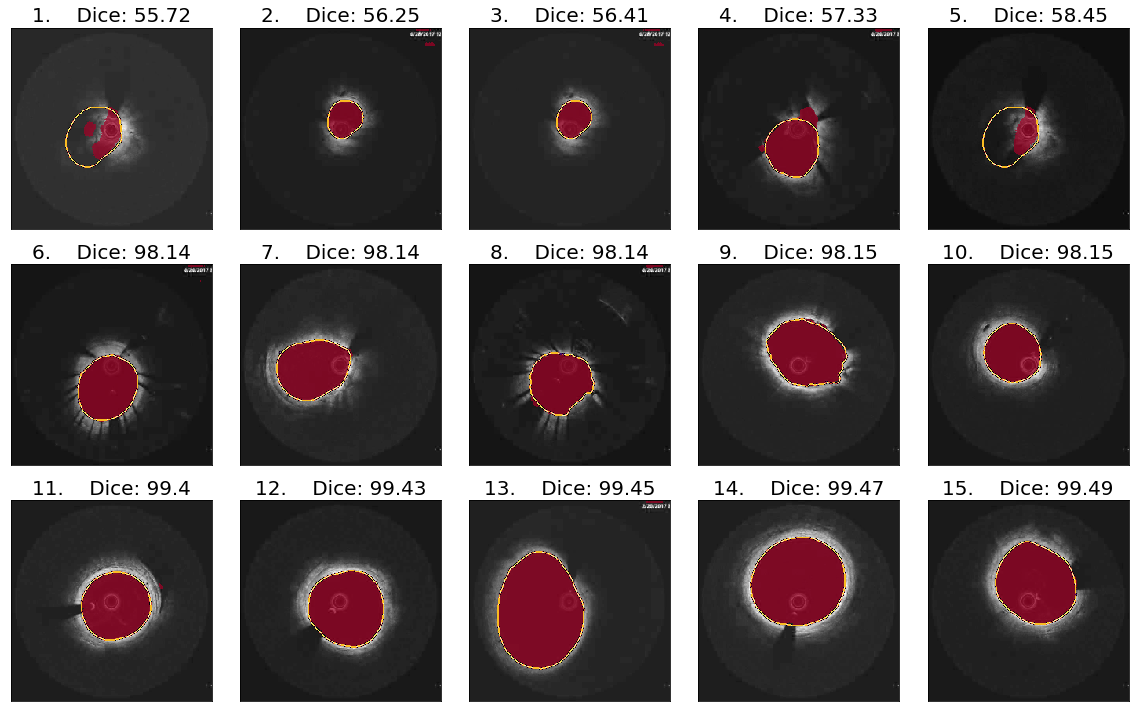

In [85]:
analysis.worst_to_best(which_ones, sorted_dices, False)

In [86]:
four = sorted_dices['path'][[
                      '0009181.jpg',
                      '0011011.jpg',
                      '0002096.jpg',
                      '0002089.jpg',
                      '0010132.jpg',
                      '0001134.jpg',
                      '0002081.jpg',
                        '0009684.jpg']]
four = four[[0,2,4,-1]]

others = sorted_dices['path'][['0003448.jpg', 
                             '0009181.jpg',
                             '0011011.jpg',
                             '0002096.jpg',
                             '0002089.jpg',
                             '0010132.jpg',
                             '0001134.jpg',
                             '0002081.jpg']]
others = others[[0,2,4,-1]]

**Some interesting cases**

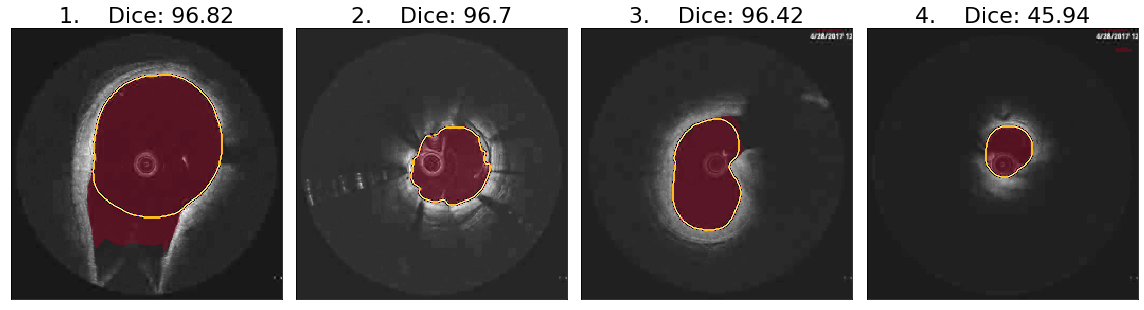

In [87]:
analysis.show_interestingx4(four, sorted_dices, False)

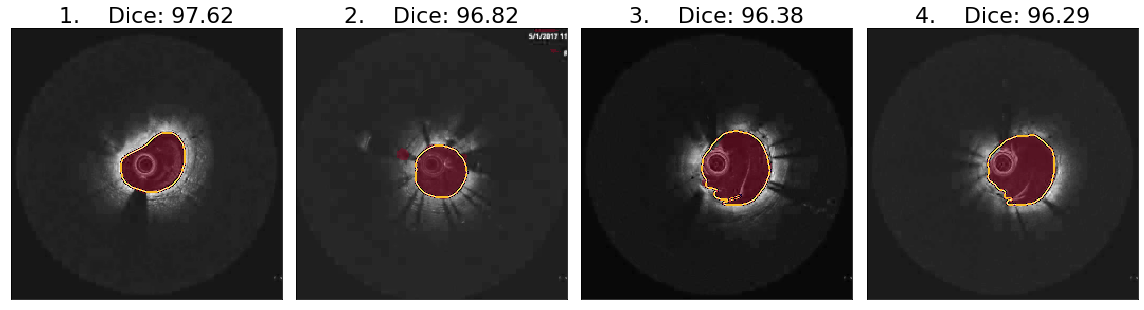

In [88]:
analysis.show_interestingx4(others, sorted_dices, False)

## Conclusion

* We found that our model performed the best, as measured by mean pixel accuracy and soft Dice score, **99.5%** and **97.1%** respectively, on a validation dataset.
* Our model strikes a new benchmark in automated production of consistently high-quality coronary artery lumen segmentations.
* We designed the model with a clinical use case in mind and as such the model doesn’t require image modification or exclusion prior to being able to output segments.
* Furthermore, the model performs fast, being able to segment an entire 200 image B-scan in about **12 seconds**, which is important for future clinical applications.

## Script check

In [154]:
script_path = Path('/workspace/oct_ca_seg/two_cases/d/images')

In [44]:
preds_paths = scriptpath/'preds'

In [155]:
i_paths = get_files(scriptpath)

In [156]:
len(i_paths)

269

In [165]:
len(script_d)

269

In [166]:
script_d = OCTDataset(Path('/workspace/oct_ca_seg/two_cases/d/images'), i_paths, opts.start_size,opts.c_size,opts.transforms,opts.input_images, opts.cuda)
script_d_loader = DataLoader(script_d, batch_size=1, shuffle=False)

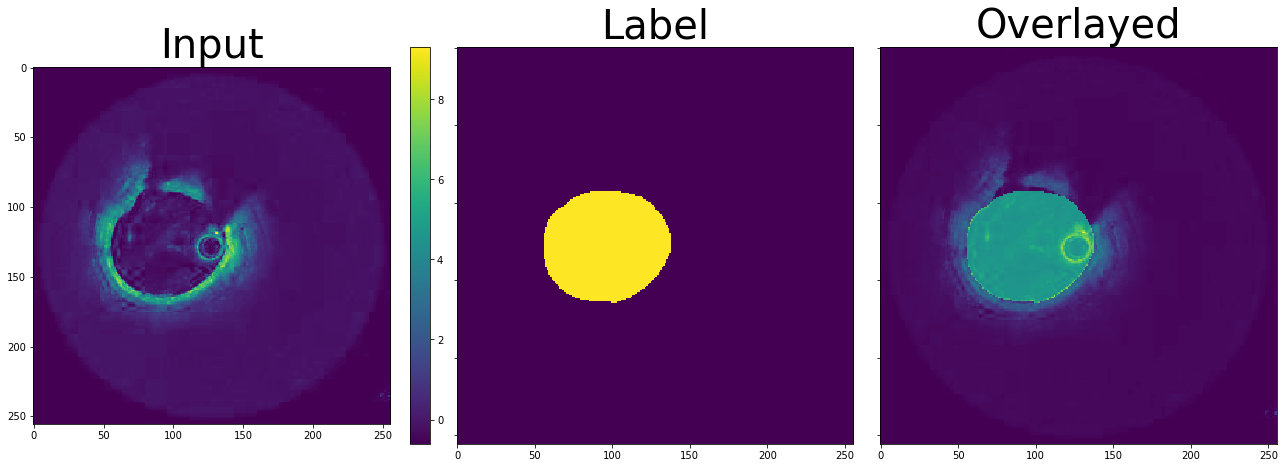

In [167]:
script_d.visualise(50)

In [58]:
import PIL.Image as I

In [111]:
dice = []
for pred_n in preds:
    name = pred_n.name
    label_n = pred_n.parent.parent/('labels/'+name) 
    pred = torch.tensor(np.asarray(I.open(pred_n))[:,:,0][None,:,:]).float()
    label = torch.tensor(np.asarray(I.open(label_n))[:,:,0][None,:,:]).float()
    pred[pred>0] = 1
    label[label>0] = 1
    l = lossdice(pred, label)
    dice += [l]

In [114]:
np.array(dice).()

0.9392734

In [160]:
model.eval();

In [161]:
model = model.cuda()

In [162]:
metric_data_script = pd.DataFrame(columns=['sensitivity', 'specificity', 'dice', 'accuracy', 'loss'])

In [168]:
%%time 
#valid loop
for i, sample in enumerate(script_d_loader): 
    xb, yb, name = sample['input'].cuda(), sample['label'].cuda(), sample['case_name'][0][0]
    #yb = torch.tensor(np.asarray(I.open(label_n))[:,:,0][None,:,:]).float()
    pred = model(xb)[0]
    loss = new_loss(pred, channelify(yb))
    
    #now we want to save metrics for analysis 
    sn = float(sens(pred, yb).cpu())
    spn = float(spec(pred,yb).cpu())
    dn = float(mydice(pred, yb).cpu())
    accn = float(acc(pred,yb).cpu())
    metric_data_script.loc[name] = [sn,spn,dn,accn, float(loss.data.cpu())]

CPU times: user 1min 50s, sys: 11.7 s, total: 2min 2s
Wall time: 20.4 s


In [169]:
metric_data_script

,sensitivity,specificity,dice,accuracy,loss
0010696.jpg,0.857677,0.977569,0.923386,0.980240,0.101469
0001343.jpg,0.969658,0.996373,0.984595,0.996750,0.064911
0007889.jpg,0.977448,0.998626,0.988595,0.998703,0.059000
0007897.jpg,0.956916,0.997230,0.977984,0.997391,0.060627
0002507.jpg,0.957182,0.993837,0.978123,0.994583,0.071297
...,...,...,...,...,...
IMG_001_00267.jpg,0.902848,0.990357,0.948944,0.991150,0.076597
IMG_001_00189.jpg,0.939504,0.993573,0.968809,0.994156,0.069071
IMG_001_00003.jpg,0.937928,0.995415,0.967970,0.995712,0.065213
IMG_001_00048.jpg,0.973651,0.997168,0.986650,0.997437,0.063762


In [172]:
metric_data_script['dice'].median()

0.9830358624458313